# Spectral Entropy Analysis

### Hypothesis
1. Spectral entropy measures how "disordered" or random a signal is in the frequency domain. 
2. Higher spectral entropy indicates more randomness or disorder in the signal.
3. We hypothesize that spectral entropy will be higher in people with schizophrenia than in healthy controls.
4. We are also open to the possibility that it might be higher in MDD than in HC.

### Analysis Outline
We compute the mean Spectral Entropy (SE):
1. On a global scale (`global_SE`), for the entire set of chosen regions (auditory, visual, motor, dmn, fpn, salience, limbic)
2. On a meso scale, for `unimodal_SE` (auditory, visual, motor) and `transmodal_SE` (dmn, fpn, salience, limbic)
3. On a network scale, for the individual networks (`auditory_SE`, `visual_SE`, `motor_SE`, `dmn_SE`, `fpn_SE`, `salience_SE`, `limbic_SE`)

We then perform a series of statistical tests to compare the SE between groups (HC, SZ, MDD).

In [1]:
# Import the necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import entropy
from scipy import signal
import matplotlib.pyplot as plt
import arviz as az



In [2]:
# Load the timeseries data
data_dir = Path('/Users/fdjim/Desktop/PDS_CODE/timeseries')
timeseries_hc_path = data_dir / 'timeseries_data_wide_hc.csv'
timeseries_mdd_path = data_dir / 'timeseries_data_wide_mdd.csv'
timeseries_sz_path = data_dir / 'timeseries_data_wide_sz.csv'

# Function to reshape dataframe
def reshape_timeseries_df(df):
    # Get timepoint columns
    timepoint_cols = [col for col in df.columns if 'timepoint' in col]
    
    # Convert timepoint columns to array
    df['timeseries'] = df[timepoint_cols].values.tolist()
    
    # Keep only relevant columns
    df = df[['group', 'subject', 'region', 'timeseries']]
    
    return df

# Read and process individual dataframes
df_hc = pd.read_csv(timeseries_hc_path)
df_mdd = pd.read_csv(timeseries_mdd_path)
df_sz = pd.read_csv(timeseries_sz_path)

# Add group column to each dataframe
df_hc['group'] = 'HC'
df_mdd['group'] = 'MDD'
df_sz['group'] = 'SZ'

# Reshape each dataframe
df_hc = reshape_timeseries_df(df_hc)
df_mdd = reshape_timeseries_df(df_mdd)
df_sz = reshape_timeseries_df(df_sz)

# Move group column to front if needed
df_hc = df_hc[['group'] + [col for col in df_hc.columns if col != 'group']]
df_mdd = df_mdd[['group'] + [col for col in df_mdd.columns if col != 'group']]
df_sz = df_sz[['group'] + [col for col in df_sz.columns if col != 'group']]

# Combine all dataframes
df_combined = pd.concat([df_hc, df_mdd, df_sz], axis=0, ignore_index=True)

In [3]:
def create_consistent_region_labels(df):
    """
    Create consistent region labels based on the first subject's pattern
    """
    # Get first subject as reference
    reference_subject = df['subject'].iloc[0]
    ref_data = df[df['subject'] == reference_subject]
    
    # Create label mapping based on reference subject
    label_mapping = {}
    for region in ref_data['region'].unique():
        # Count occurrences of each region in reference subject
        n_occurrences = len(ref_data[ref_data['region'] == region])
        # Create labels for this region (e.g., auditory_1, auditory_2, etc.)
        label_mapping[region] = [f"{region}_{i+1}" for i in range(n_occurrences)]
    
    # Apply labels to entire dataset
    df['region_numbered'] = ''
    
    # For each subject
    for subject in df['subject'].unique():
        subject_data = df[df['subject'] == subject]
        
        # For each region
        for region in label_mapping.keys():
            # Get the indices for this region in this subject
            region_indices = df[(df['subject'] == subject) & 
                              (df['region'] == region)].index
            
            # Apply labels in order
            for idx, label in zip(region_indices, label_mapping[region]):
                df.loc[idx, 'region_numbered'] = label
    
    return df

# Apply the labeling
df_combined = create_consistent_region_labels(df_combined)

# Drop the original region column and rename region_numbered to region
df_combined = df_combined.drop('region', axis=1)
df_combined = df_combined.rename(columns={'region_numbered': 'region'})
# Reorder columns to make region the third column
df_combined = df_combined[['group', 'subject', 'region', 'timeseries']]
df_combined

group   subject      region  \
0       HC  sub-005C  auditory_1   
1       HC  sub-005C  auditory_2   
2       HC  sub-005C  auditory_3   
3       HC  sub-005C  auditory_4   
4       HC  sub-005C    visual_1   
...    ...       ...         ...   
2191    SZ  sub-071P  salience_4   
2192    SZ  sub-071P    limbic_1   
2193    SZ  sub-071P    limbic_2   
2194    SZ  sub-071P    limbic_3   
2195    SZ  sub-071P    limbic_4   

                                             timeseries  
0     [-0.23212396, -1.2979008, -2.4941385, -0.30209...  
1     [-0.0003509258, 0.77697676, -0.9753578, 0.0136...  
2     [-0.10847709, -0.5882271, -0.46752557, 0.54532...  
3     [0.06650891, 1.5935814, 0.4620008, 0.50516576,...  
4     [-0.08599097, 1.6486676, 0.65873665, 0.9097465...  
...                                                 ...  
2191  [0.34683806, 1.4288366, 1.2474, 0.35556355, 0....  
2192  [0.10106625, 0.32320738, 2.0998945, 1.1311909,...  
2193  [0.023173295, -0.8265899, 0.8209988, -0.162468...  
2194  [0.027429515, -1.219181, 2.3719673, 0.37863398...  
2195  [-0.09484818, -1.0171264, 0.89353526, 0.634770...  

[2196 rows x 4 columns]

## **Spectral entropy computation**

In [4]:
# Define the spectral entropy computation function

def compute_spectral_entropy(timeseries, TR=2.0, nperseg=None):
    """
    Compute spectral entropy for a given timeseries
    """
    # Convert TR to sampling frequency (fs = 1/TR)
    fs = 1/TR
    
    # If nperseg is not specified, use half the length of the timeseries
    if nperseg is None:
        nperseg = len(timeseries)//2
    
    # Compute power spectral density using Welch's method
    frequencies, psd = signal.welch(timeseries, fs=fs, nperseg=nperseg)
    
    # Normalize PSD to sum to 1 (make it a probability distribution)
    psd_norm = psd / psd.sum()
    
    # Compute Shannon entropy of the normalized PSD
    spec_ent = entropy(psd_norm)
    
    return spec_ent

df_combined['spectral_entropy'] = df_combined['timeseries'].apply(compute_spectral_entropy)

df_combined.head(50)

group   subject      region  \
0     HC  sub-005C  auditory_1   
1     HC  sub-005C  auditory_2   
2     HC  sub-005C  auditory_3   
3     HC  sub-005C  auditory_4   
4     HC  sub-005C    visual_1   
5     HC  sub-005C    visual_2   
6     HC  sub-005C    visual_3   
7     HC  sub-005C    visual_4   
8     HC  sub-005C    visual_5   
9     HC  sub-005C    visual_6   
10    HC  sub-005C    visual_7   
11    HC  sub-005C    visual_8   
12    HC  sub-005C    visual_9   
13    HC  sub-005C   visual_10   
14    HC  sub-005C     motor_1   
15    HC  sub-005C     motor_2   
16    HC  sub-005C     motor_3   
17    HC  sub-005C     motor_4   
18    HC  sub-005C       dmn_1   
19    HC  sub-005C       dmn_2   
20    HC  sub-005C       dmn_3   
21    HC  sub-005C       dmn_4   
22    HC  sub-005C       dmn_5   
23    HC  sub-005C       dmn_6   
24    HC  sub-005C       fpn_1   
25    HC  sub-005C       fpn_2   
26    HC  sub-005C       fpn_3   
27    HC  sub-005C       fpn_4   
28    HC  sub-005C  salience_1   
29    HC  sub-005C  salience_2   
30    HC  sub-005C  salience_3   
31    HC  sub-005C  salience_4   
32    HC  sub-005C    limbic_1   
33    HC  sub-005C    limbic_2   
34    HC  sub-005C    limbic_3   
35    HC  sub-005C    limbic_4   
36    HC  sub-006C  auditory_1   
37    HC  sub-006C  auditory_2   
38    HC  sub-006C  auditory_3   
39    HC  sub-006C  auditory_4   
40    HC  sub-006C    visual_1   
41    HC  sub-006C    visual_2   
42    HC  sub-006C    visual_3   
43    HC  sub-006C    visual_4   
44    HC  sub-006C    visual_5   
45    HC  sub-006C    visual_6   
46    HC  sub-006C    visual_7   
47    HC  sub-006C    visual_8   
48    HC  sub-006C    visual_9   
49    HC  sub-006C   visual_10   

                                           timeseries  spectral_entropy  
0   [-0.23212396, -1.2979008, -2.4941385, -0.30209...          4.015474  
1   [-0.0003509258, 0.77697676, -0.9753578, 0.0136...          3.935006  
2   [-0.10847709, -0.5882271, -0.46752557, 0.54532...          4.008696  
3   [0.06650891, 1.5935814, 0.4620008, 0.50516576,...          3.892474  
4   [-0.08599097, 1.6486676, 0.65873665, 0.9097465...          3.654560  
5   [-0.13079695, 1.4102573, 0.3170967, 0.844801, ...          3.669695  
6   [0.029353296, 2.037707, 1.9742737, 1.6590232, ...          4.015036  
7   [0.0019713833, 2.1241477, 1.7496566, 2.059809,...          3.867333  
8   [0.00047513752, 1.3669599, 0.86673725, 2.00265...          3.506906  
9   [0.04276746, 0.530269, -0.09806236, 2.028575, ...          3.971859  
10  [0.004885677, 1.4945995, 2.0424633, 2.176924, ...          4.036017  
11  [-0.024941295, 1.5516335, 0.9379929, 2.2446012...          3.777430  
12  [-0.14611915, 2.089038, 0.68876344, 1.3264235,...          3.816964  
13  [0.037143562, 2.213002, 0.54395366, 1.3342301,...          3.752601  
14  [-0.16569264, 0.08234888, -1.0750124, -0.93903...          4.042571  
15  [0.17731294, 1.3872378, 0.5553646, 0.49823198,...          3.878685  
16  [0.06472433, 1.030708, 0.57185215, 1.2108151, ...          3.950013  
17  [0.10694171, -0.45447868, -0.34993964, 0.63401...          4.102879  
18  [0.03509709, 0.24969912, 0.32896167, 0.2519049...          3.764449  
19  [0.045776606, 0.5803861, 0.32951495, 0.38234, ...          3.995633  
20  [0.20584689, -0.05150204, -0.15094364, 0.17435...          4.147673  
21  [0.29633605, -0.48814726, 0.2385996, 0.3928380...          4.113191  
22  [-0.0589222, -0.005429146, -0.60319406, -0.176...          4.040031  
23  [0.16508597, 0.37504187, -0.11316683, 0.375252...          3.854608  
24  [0.078154154, -0.7485802, -0.29172787, 0.90476...          3.992101  
25  [0.076965146, -0.39638874, -1.2930145, -0.2860...          3.917444  
26  [-0.11025667, -0.67700803, -2.0939336, -0.1823...          4.009708  
27  [0.006210158, -0.48017594, -1.3353474, -0.0936...          3.742510  
28  [-0.22813705, -0.13058583, -0.24990687, 2.0485...          3.996953  
29  [-0.03353484, 0.46818522, -0.026613332, 1.17

### **Global Scale Spectral Entropy**
- Compute summary statistics by group (HC, MDD, SZ)
- Test for normality (Shapiro-Wilk)
- Compute the variability within each group using SD of the SE


Descriptive Statistics by Group:
         Mean      SD  Median     IQR
group                                
HC     3.9216  0.2018  3.9629  0.2296
MDD    3.9946  0.1877  4.0640  0.1750
SZ     4.0127  0.1425  4.0521  0.1553

Shapiro-Wilk Normality Test:
HC: W = 0.8813, p = 0.0000
MDD: W = 0.7890, p = 0.0000
SZ: W = 0.8502, p = 0.0000


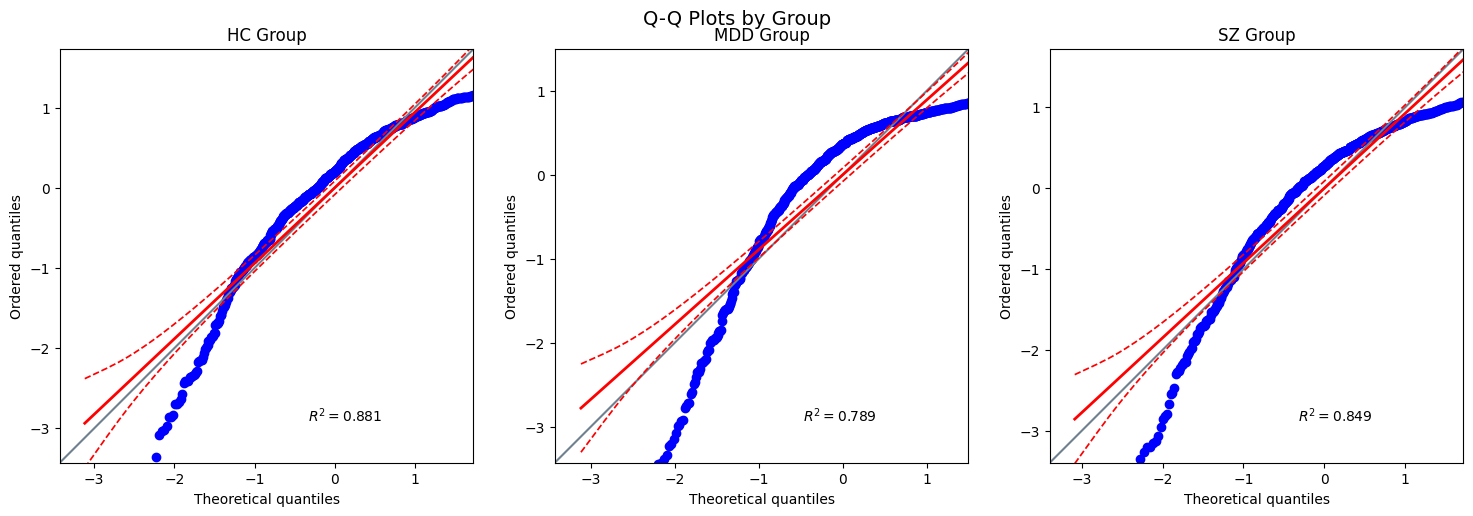

In [5]:
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

# Calculate mean, SD, median and IQR by group
group_stats = df_combined.groupby('group')['spectral_entropy'].agg([
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('Median', 'median'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(4)

# Calculate IQR
group_stats['IQR'] = (group_stats['Q3'] - group_stats['Q1']).round(4)

# Display basic statistics
print("\nDescriptive Statistics by Group:")
print("==============================")
print(group_stats[['Mean', 'SD', 'Median', 'IQR']])

# Shapiro-Wilk test for each group
print("\nShapiro-Wilk Normality Test:")
print("===========================")
for group in df_combined['group'].unique():
    stat, p = stats.shapiro(df_combined[df_combined['group'] == group]['spectral_entropy'])
    print(f"{group}: W = {stat:.4f}, p = {p:.4f}")

# QQ plots using pingouin
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Q-Q Plots by Group', fontsize=14)

for idx, group in enumerate(df_combined['group'].unique()):
    group_data = df_combined[df_combined['group'] == group]['spectral_entropy']
    pg.qqplot(group_data, ax=axes[idx])
    axes[idx].set_title(f'{group} Group')

plt.tight_layout()
plt.show()

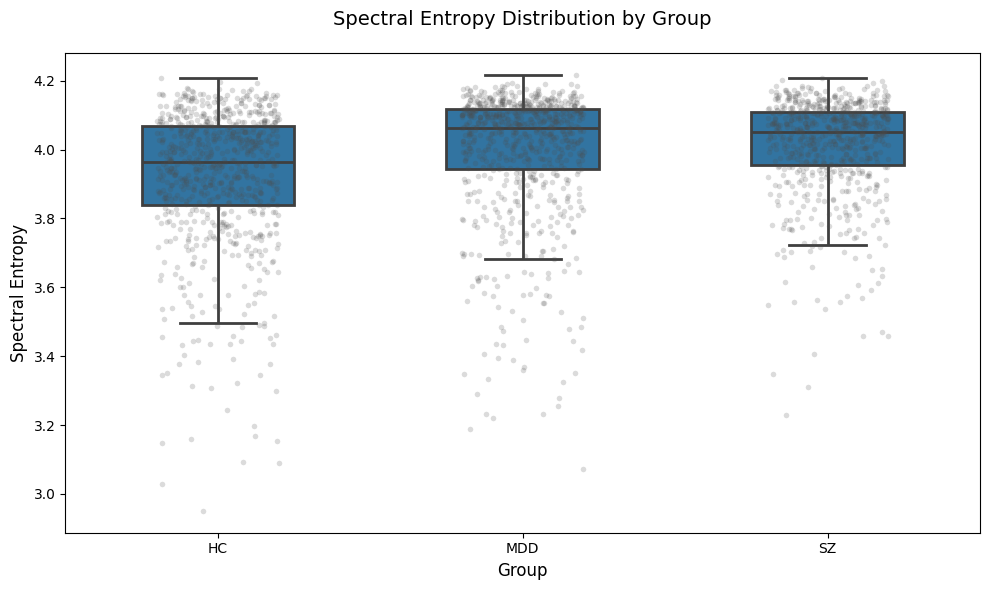

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# Create box plot with overlaid data points
# boxplot with thicker lines
sns.boxplot(x='group', y='spectral_entropy', data=df_combined, 
            width=0.5, 
            linewidth=2,
            showfliers=False)

# Add individual points with transparency
sns.stripplot(x='group', y='spectral_entropy', data=df_combined,
              color='0.3',  # Gray color
              alpha=0.2,    # Transparency
              size=4,       # Point size
              jitter=0.2)   # Amount of jitter

# Customize the plot
plt.title('Spectral Entropy Distribution by Group', fontsize=14, pad=20)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Spectral Entropy', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

#### **Meso Scale Spectral Entropy**


Descriptive Statistics by Group and Scale:
                    Mean      SD  Median     IQR
group scale                                     
HC    transmodal  3.9881  0.1339  4.0200  0.1842
      unimodal    3.8552  0.2340  3.9044  0.2767
MDD   transmodal  4.0532  0.1100  4.0912  0.1173
      unimodal    3.9359  0.2270  4.0121  0.2529
SZ    transmodal  4.0478  0.1066  4.0771  0.1199
      unimodal    3.9777  0.1639  4.0267  0.1787

Shapiro-Wilk Normality Test:

HC:
unimodal: W = 0.9088, p = 0.0000
transmodal: W = 0.9361, p = 0.0000

MDD:
unimodal: W = 0.8389, p = 0.0000
transmodal: W = 0.8514, p = 0.0000

SZ:
unimodal: W = 0.8630, p = 0.0000
transmodal: W = 0.8906, p = 0.0000


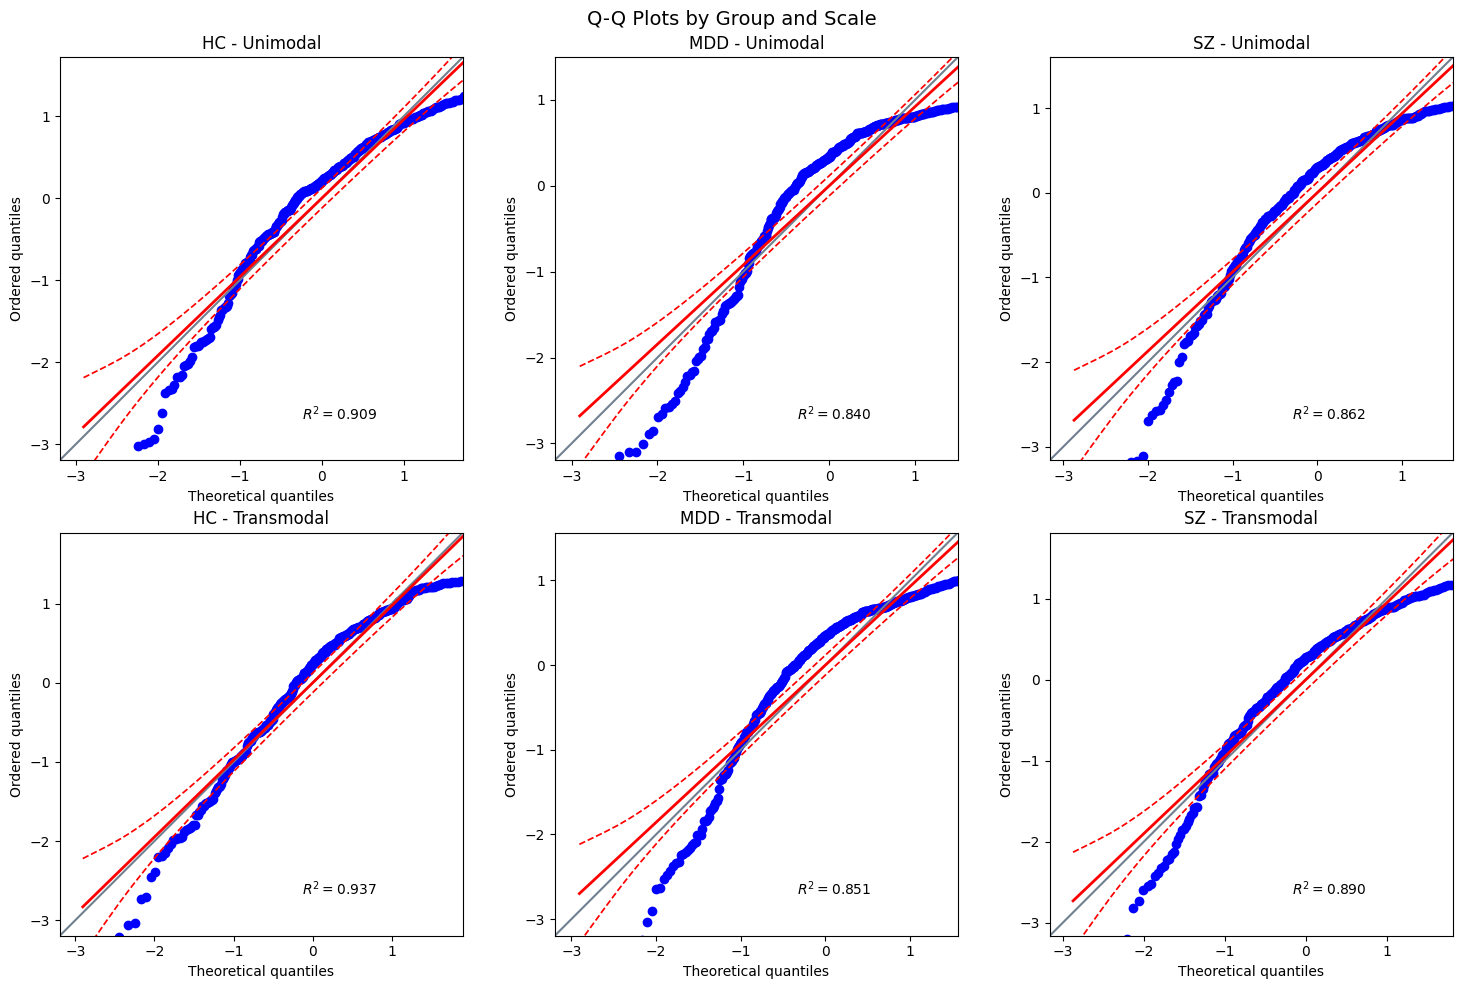

In [7]:
# First create a new column to classify regions as unimodal or transmodal
df_combined['scale'] = df_combined['region'].apply(lambda x: 
    'unimodal' if x.startswith(('auditory', 'visual', 'motor')) 
    else 'transmodal')

# Calculate mean, SD, median and IQR by group and scale
scale_stats = df_combined.groupby(['group', 'scale'])['spectral_entropy'].agg([
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('Median', 'median'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(4)

# Calculate IQR
scale_stats['IQR'] = (scale_stats['Q3'] - scale_stats['Q1']).round(4)

# Display basic statistics
print("\nDescriptive Statistics by Group and Scale:")
print("=======================================")
print(scale_stats[['Mean', 'SD', 'Median', 'IQR']])

# Shapiro-Wilk test for each group and scale combination
print("\nShapiro-Wilk Normality Test:")
print("===========================")
for group in df_combined['group'].unique():
    print(f"\n{group}:")
    for scale in df_combined['scale'].unique():
        data = df_combined[(df_combined['group'] == group) & 
                          (df_combined['scale'] == scale)]['spectral_entropy']
        stat, p = stats.shapiro(data)
        print(f"{scale}: W = {stat:.4f}, p = {p:.4f}")

# QQ plots using pingouin
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Q-Q Plots by Group and Scale', fontsize=14)

for idx, group in enumerate(df_combined['group'].unique()):
    for scale_idx, scale in enumerate(df_combined['scale'].unique()):
        data = df_combined[(df_combined['group'] == group) & 
                          (df_combined['scale'] == scale)]['spectral_entropy']
        pg.qqplot(data, ax=axes[scale_idx, idx])
        axes[scale_idx, idx].set_title(f'{group} - {scale.capitalize()}')

plt.tight_layout()
plt.show()

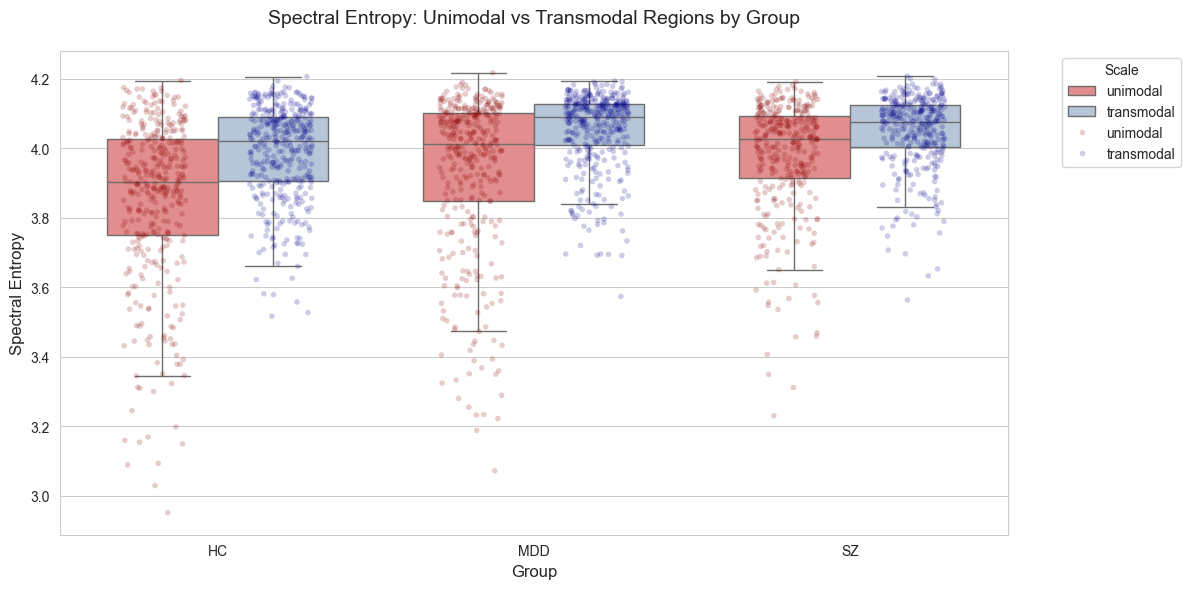

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create boxplot with points
sns.boxplot(x='group', y='spectral_entropy', hue='scale', 
            data=df_combined,
            palette=['lightcoral', 'lightsteelblue'],
            width=0.7,
            showfliers=False)

# Add individual points with jitter
sns.stripplot(x='group', y='spectral_entropy', hue='scale',
              data=df_combined,
              palette=['darkred', 'darkblue'],
              alpha=0.2,
              size=4,
              jitter=0.2,
              dodge=True)

# Customize the plot
plt.title('Spectral Entropy: Unimodal vs Transmodal Regions by Group', fontsize=14, pad=20)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Spectral Entropy', fontsize=12)

# Adjust legend
plt.legend(title='Scale', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

#### **Network Scale Spectral Entropy**

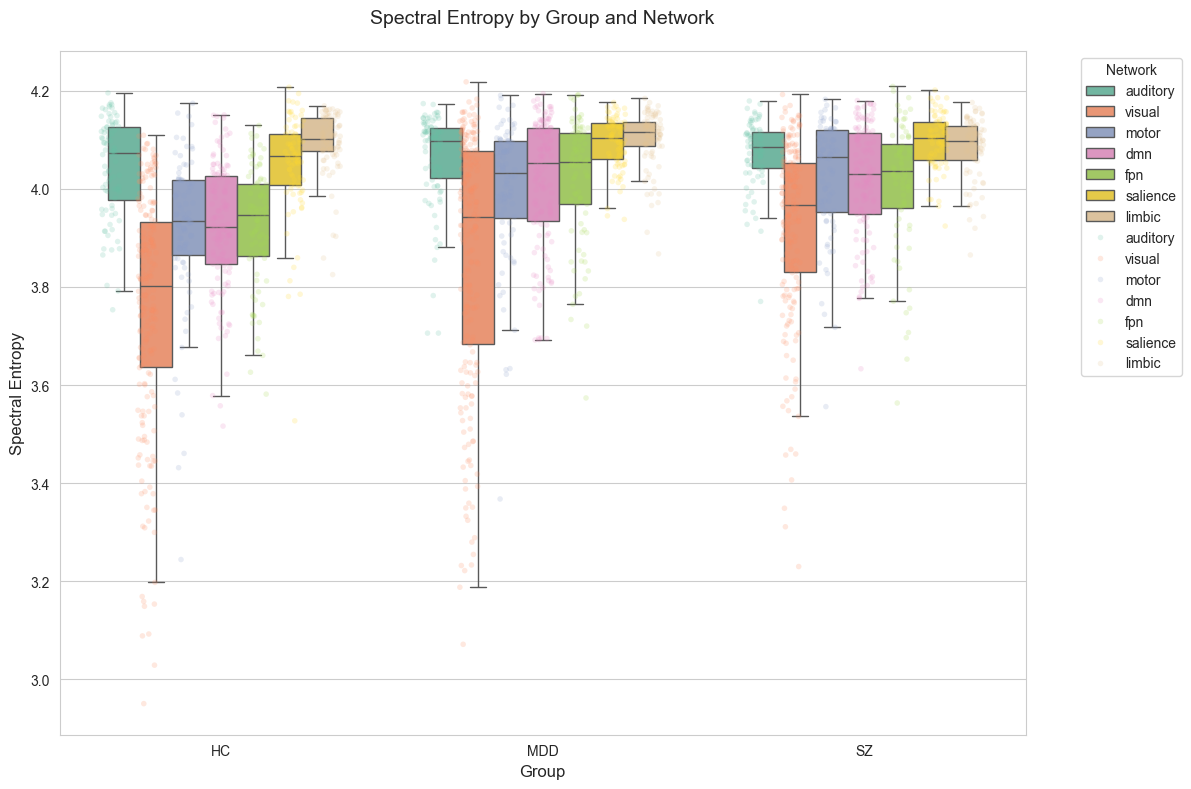


Descriptive Statistics by Group and Network:
                  Mean      SD  Median     IQR
group network                                 
HC    auditory  4.0430  0.1006  4.0723  0.1485
      dmn       3.9215  0.1300  3.9224  0.1794
      fpn       3.9228  0.1224  3.9466  0.1469
      limbic    4.0928  0.0658  4.1017  0.0672
      motor     3.9134  0.1610  3.9352  0.1514
      salience  4.0485  0.1043  4.0664  0.1033
      visual    3.7568  0.2432  3.8028  0.2961
MDD   auditory  4.0616  0.0966  4.0980  0.1018
      dmn       4.0151  0.1310  4.0526  0.1899
      fpn       4.0218  0.1250  4.0548  0.1454
      limbic    4.1004  0.0596  4.1165  0.0493
      motor     3.9959  0.1455  4.0315  0.1574
      salience  4.0948  0.0527  4.1039  0.0734
      visual    3.8616  0.2598  3.9433  0.3943
SZ    auditory  4.0715  0.0693  4.0851  0.0735
      dmn       4.0188  0.1151  4.0308  0.1657
      fpn       4.0077  0.1333  4.0357  0.1307
      limbic    4.0819  0.0651  4.0981  0.0697
      motor   

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract network name from region (remove numbers)
df_combined['network'] = df_combined['region'].apply(lambda x: x.split('_')[0])

# Set figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create boxplot without outliers
sns.boxplot(x='group', y='spectral_entropy', hue='network', 
            data=df_combined,
            palette='Set2',  # Using a colorblind-friendly palette
            width=0.7,
            showfliers=False)

# Add individual points with jitter
sns.stripplot(x='group', y='spectral_entropy', hue='network',
              data=df_combined,
              palette='Set2',
              alpha=0.2,
              size=4,
              jitter=0.2,
              dodge=True)

# Customize the plot
plt.title('Spectral Entropy by Group and Network', fontsize=14, pad=20)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Spectral Entropy', fontsize=12)

# Adjust legend
plt.legend(title='Network', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          ncol=1)  # Stack legend items vertically

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print descriptive statistics for each group by network
network_stats = df_combined.groupby(['group', 'network'])['spectral_entropy'].agg([
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('Median', 'median'),
    ('IQR', lambda x: x.quantile(0.75) - x.quantile(0.25))
]).round(4)

print("\nDescriptive Statistics by Group and Network:")
print("=========================================")
print(network_stats)

### Visualize the results

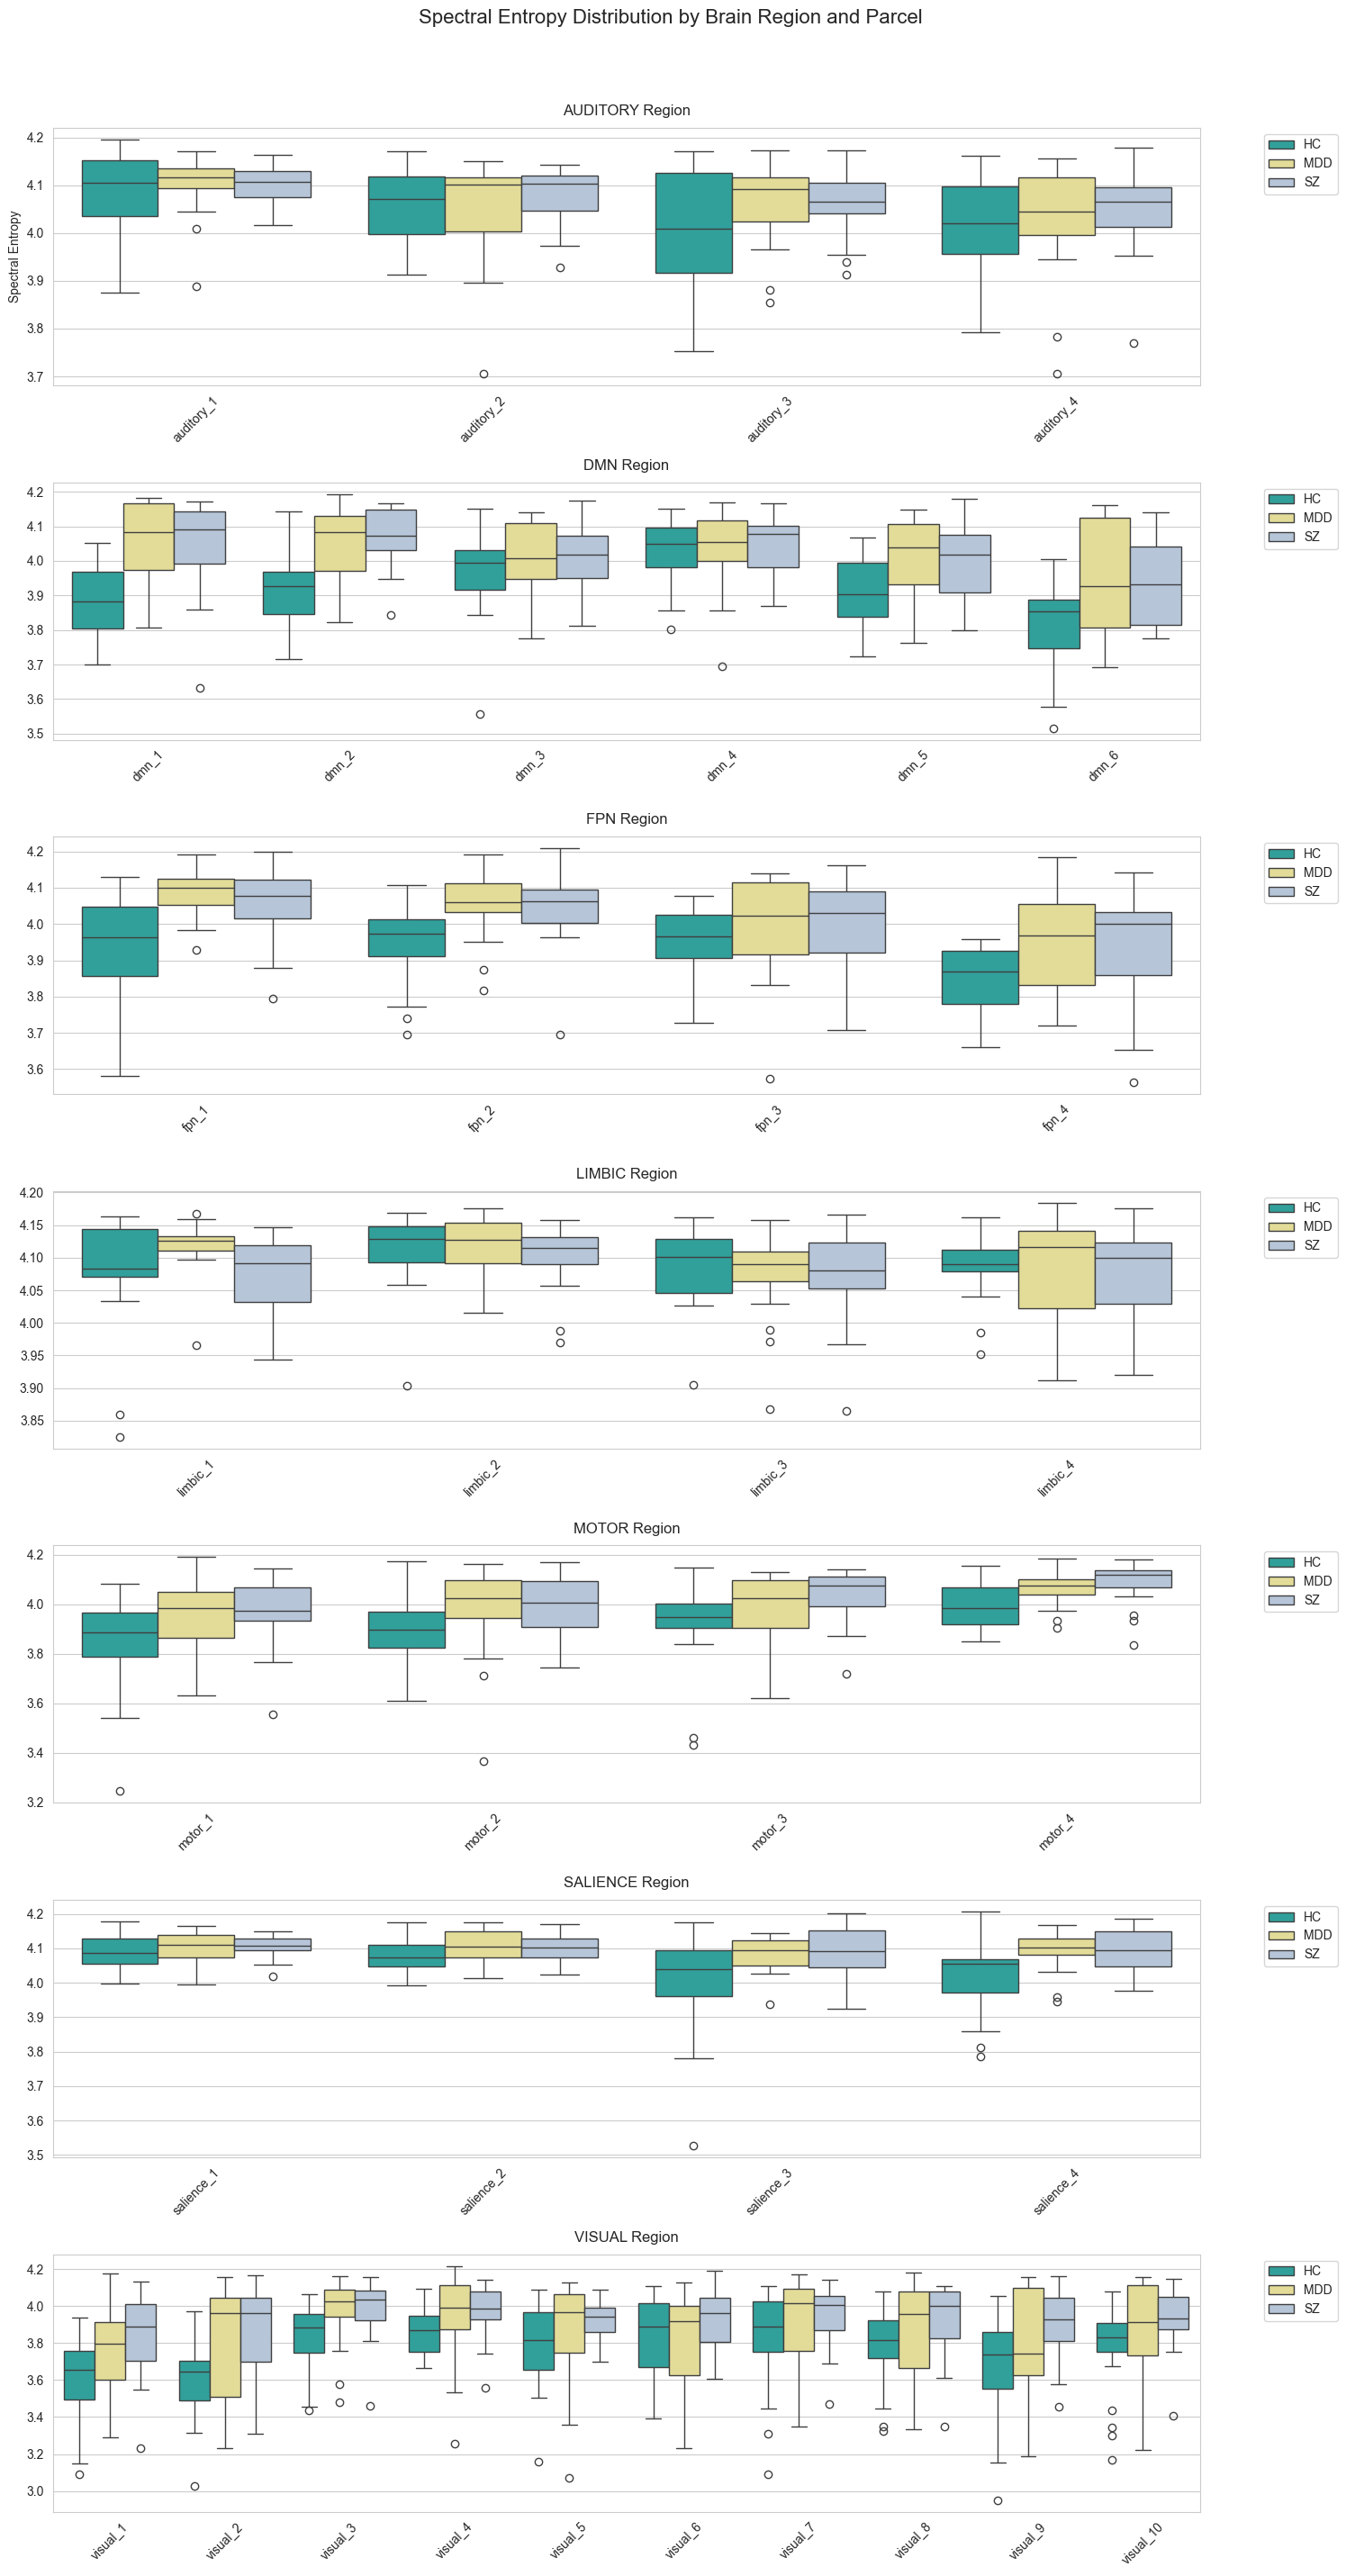

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract unique regions without parcel numbers
major_regions = sorted(list(set([reg.split('_')[0] for reg in df_combined['region'].unique()])))
n_major_regions = len(major_regions)

# Set up the figure
fig, axes = plt.subplots(n_major_regions, 1, figsize=(15, 4*n_major_regions))
fig.suptitle('Spectral Entropy Distribution by Brain Region and Parcel', fontsize=16, y=1.02)

# Color palette for groups
colors = {'HC': 'lightseagreen', 'MDD': 'khaki', 'SZ': 'lightsteelblue'}

# Create subplot for each major region
for idx, region in enumerate(major_regions):
    # Get data for this region
    region_data = df_combined[df_combined['region'].str.startswith(region)]
    
    # Create boxplot for this region
    sns.boxplot(data=region_data, 
                x='region', 
                y='spectral_entropy',
                hue='group',
                palette=colors,
                ax=axes[idx])
    
    # Customize subplot
    axes[idx].set_title(f'{region.upper()} Region', fontsize=12, pad=10)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Spectral Entropy' if idx == 0 else '')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Move legend outside plot
    axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Mixed Effects Model

Workflow:
- prior predictive check
- posterior 
- trace plots
- arviz summary (supp)
- forest plot to visualize the model

- LOOCV

In [127]:
# Remove the timeseries column as it's not needed for the model
df_model = df_combined.drop('timeseries', axis=1)
# Convert group to binary (assuming we're comparing HC vs SZ)
df_model['group_binary'] = (df_model['group'] == 'SZ').astype(int)
# Verify the conversion
print("\nGroup encoding:")
print(df_model['group_binary'].value_counts())
# Z-score spectral entropy
df_model['spectral_entropy_z'] = (df_model['spectral_entropy'] - df_model['spectral_entropy'].mean()) / df_model['spectral_entropy'].std()


Group encoding:
group_binary
0    1512
1     684
Name: count, dtype: int64


**Built and Fit the Mixed Effects Model**

In [128]:
import bambi as bmb

tyler = bmb.Model(
    'group_binary ~ spectral_entropy_z + (spectral_entropy_z|network)',
    data=df_model,
    family='bernoulli'
)

# Fit models
results_tyler = tyler.fit(draws=1000, tune=1000, chains=4, target_accept=0.95)


Modeling the probability that group_binary==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, spectral_entropy_z, 1|network_sigma, 1|network_offset, spectral_entropy_z|network_sigma, spectral_entropy_z|network_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [130]:
# Create new variables to observe the total effect of spectral entropy on group membership

results_tyler.posterior['spectral_entropy_z + spectral_entropy_z|network'] = (
    results_tyler.posterior['spectral_entropy_z'] + 
    results_tyler.posterior['spectral_entropy_z|network']
)

summary = az.summary(results_tyler, hdi_prob=0.94)

**Compute the Probability of Direction and ROPE for the effects in the model**

Probability of Direction (PD)
- The Probability of Direction (PD) is a measure of the certainty about whether an effect is positive or negative
- It ranges from 50% to 100%
- A PD of 95% means there's a 95% probability that the true effect is positive (or negative)
- It's considered a more intuitive alternative to the p-value
- The higher the PD, the more confident we can be about the direction of the effect

Region of Practical Equivalence (ROPE)
- ROPE helps determine whether an effect is practically equivalent to zero
- It defines a range of values that are considered "practically equivalent" to the null value
- For example, if you set a ROPE of [-0.1, 0.1], any effect falling within this range is considered negligible
- ROPE results are often expressed as the percentage of the posterior distribution that falls within this region
- A high percentage within ROPE suggests the effect is negligibly different from zero
- A low percentage within ROPE suggests the effect is meaningfully different from zero


In [107]:
# define functions for PD and ROPE

# Function to calculate the probability of direction
def p_direction(idata, varname):
    merged = az.extract(idata, var_names=varname)
    if len(merged.shape) == 1:
        return np.max(
            [
                np.mean(np.ravel(idata.posterior[varname]) > 0),
                np.mean(np.ravel(idata.posterior[varname]) < 0),
            ]
        )
    else:
        n_dim = merged.shape[0]
        p_direction = np.zeros(n_dim)
        for i in range(n_dim):
            data = merged.values[i]
            p_direction[i] = np.max(
                [
                    np.mean(data > 0),
                    np.mean(data < 0),
                ],
            )
        return p_direction

# Function to calculate ROPE
def rope(idata, varname, rope_range=0.18, hdi_prob=0.94):
    hdi = az.hdi(idata.posterior[varname], hdi_prob=hdi_prob)
    merged = az.extract(idata, var_names=varname)
    if len(merged.shape) == 1:
        data = np.ravel(idata.posterior[varname])
        data_in_hdi = np.logical_and(
            data >= hdi[varname].values[0], data <= hdi[varname].values[1]
        )
        data_in_rope = np.logical_or(
            data[data_in_hdi] <= -rope_range, data[data_in_hdi] >= rope_range
        )
        return np.mean(data_in_rope)
    else:
        n_dim = merged.shape[0]
        rope_result = np.zeros(n_dim)
        for i in range(n_dim):
            data = merged.values[i]
            data_in_hdi = np.logical_and(
                data >= hdi[varname].values[i][0], data <= hdi[varname].values[i][1]
            )
            data_in_rope = np.logical_or(
                data[data_in_hdi] <= -rope_range, data[data_in_hdi] >= rope_range
            )
            rope_result[i] = np.mean(data_in_rope)
        return rope_result


In [131]:
# First, define the variables you want to analyze
varnames_for_pd_rope = [
    "spectral_entropy_z",
    "1|network",
    "spectral_entropy_z|network",
    "spectral_entropy_z + spectral_entropy_z|network"
]

# Define your coordinates dictionary for the networks
coordinates_dict = {
    "network": ["auditory", "visual", "motor", "dmn", "fpn", "salience", "limbic"]  # adjust these to match your actual networks
}

# Compute PD and ROPE
for varname in varnames_for_pd_rope:
    print(f"Processing: {varname}")
    pd = p_direction(results_tyler, varname)
    r = rope(results_tyler, varname)
    
    if isinstance(r, (float, np.float64)):
        # For scalar variables
        summary.loc[varname, "pd"] = pd
        summary.loc[varname, "rope"] = r
    else:
        # For variables with network dimension
        if "|network" in varname:
            for i in range(len(r)):
                network_name = coordinates_dict["network"][i]
                name = f"{varname}[{network_name}]"
                summary.loc[name, "pd"] = pd[i]
                summary.loc[name, "rope"] = r[i]

# Save the summary to a CSV file
summary.to_csv('model_summary.csv')

Processing: spectral_entropy_z
Processing: 1|network
Processing: spectral_entropy_z|network
Processing: spectral_entropy_z + spectral_entropy_z|network


In [110]:
summary

mean     sd  hdi_3%  \
Intercept                                          -0.842  0.104  -1.057   
spectral_entropy_z                                  0.402  0.121   0.173   
1|network_sigma                                     0.180  0.114   0.000   
spectral_entropy_z|network_sigma                    0.203  0.166   0.001   
1|network[auditory]                                -0.071  0.135  -0.328   
1|network[dmn]                                      0.002  0.121  -0.234   
1|network[fpn]                                      0.007  0.128  -0.241   
1|network[limbic]                                  -0.038  0.162  -0.358   
1|network[motor]                                    0.006  0.129  -0.237   
1|network[salience]                                -0.118  0.152  -0.414   
1|network[visual]                                   0.194  0.142  -0.032   
spectral_entropy_z|network[auditory]               -0.022  0.165  -0.359   
spectral_entropy_z|network[dmn]                     0.080  0.150  -0.165   
spectral_entropy_z|network[fpn]                     0.003  0.153  -0.313   
spectral_entropy_z|network[limbic]                 -0.214  0.240  -0.689   
spectral_entropy_z|network[motor]                   0.124  0.180  -0.166   
spectral_entropy_z|network[salience]                0.030  0.182  -0.316   
spectral_entropy_z|network[visual]                 -0.003  0.123  -0.254   
spectral_entropy_z + spectral_entropy_z|network...  0.380  0.167   0.038   
spectral_entropy_z + spectral_entropy_z|network...  0.482  0.131   0.249   
spectral_entropy_z + spectral_entropy_z|network...  0.405  0.146   0.139   
spectral_entropy_z + spectral_entropy_z|network...  0.188  0.248  -0.307   
spectral_entropy_z + spectral_entropy_z|network...  0.526  0.168   0.247   
spectral_entropy_z + spectral_entropy_z|network...  0.432  0.184   0.047   
spectral_entropy_z + spectral_entropy_z|network...  0.399  0.076   0.249   

                                                    hdi_97%  mcse_mean  \
Intercept                                            -0.668      0.003   
spectral_entropy_z                                    0.636      0.003   
1|network_sigma                                       0.365      0.003   
spectral_entropy_z|network_sigma                      0.491      0.005   
1|network[auditory]                                   0.183      0.003   
1|network[dmn]                                        0.232      0.003   
1|network[fpn]                                        0.255      0.003   
1|network[limbic]                                     0.262      0.004   
1|network[motor]                                      0.257      0.003   
1|network[salience]                                   0.138      0.003   
1|network[visual]                                     0.461      0.004   
spectral_entropy_z|network[auditory]                  0.313      0.003   
spectral_entropy_z|network[dmn]                       0.408      0.003   
spectral_entropy_z|network[fpn]                       0.300      0.003   
spectral_entropy_z|network[limbic]                    0.099      0.006   
spectral_entropy_z|network[motor]                     0.496      0.004   
spectral_entropy_z|network[salience]                  0.376      0.004   
spectral_entropy_z|network[visual]                    0.238      0.003   
spectral_entropy_z + spectral_entropy_z|network...    0.693      0.003   
spectral_entropy_z + spectral_entropy_z|network...    0.736      0.002   
spectral_entropy_z + spectral_entropy_z|network...    0.712      0.002   
spectral_entropy_z + spectral_entropy_z|network...    0.548      0.007   
spectral_entropy_z + spectral_entropy_z|network...    0.856      0.003   
spectral_entropy_z + spectral_entropy_z|network...    0.773      0.004   
spectral_entropy_z + spectral_entropy_z|network...    0.533      0.001   

                                                    mcse_sd  ess_bulk  \
Intercept                                             0.002    1555.0   
spect

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'spectral_entropy_z'}>,
        <Axes: title={'center': 'spectral_entropy_z'}>],
       [<Axes: title={'center': '1|network'}>,
        <Axes: title={'center': '1|network'}>],
       [<Axes: title={'center': 'spectral_entropy_z|network'}>,
        <Axes: title={'center': 'spectral_entropy_z|network'}>],
       [<Axes: title={'center': 'spectral_entropy_z + spectral_entropy_z|network'}>,
        <Axes: title={'center': 'spectral_entropy_z + spectral_entropy_z|network'}>]],
      dtype=object)

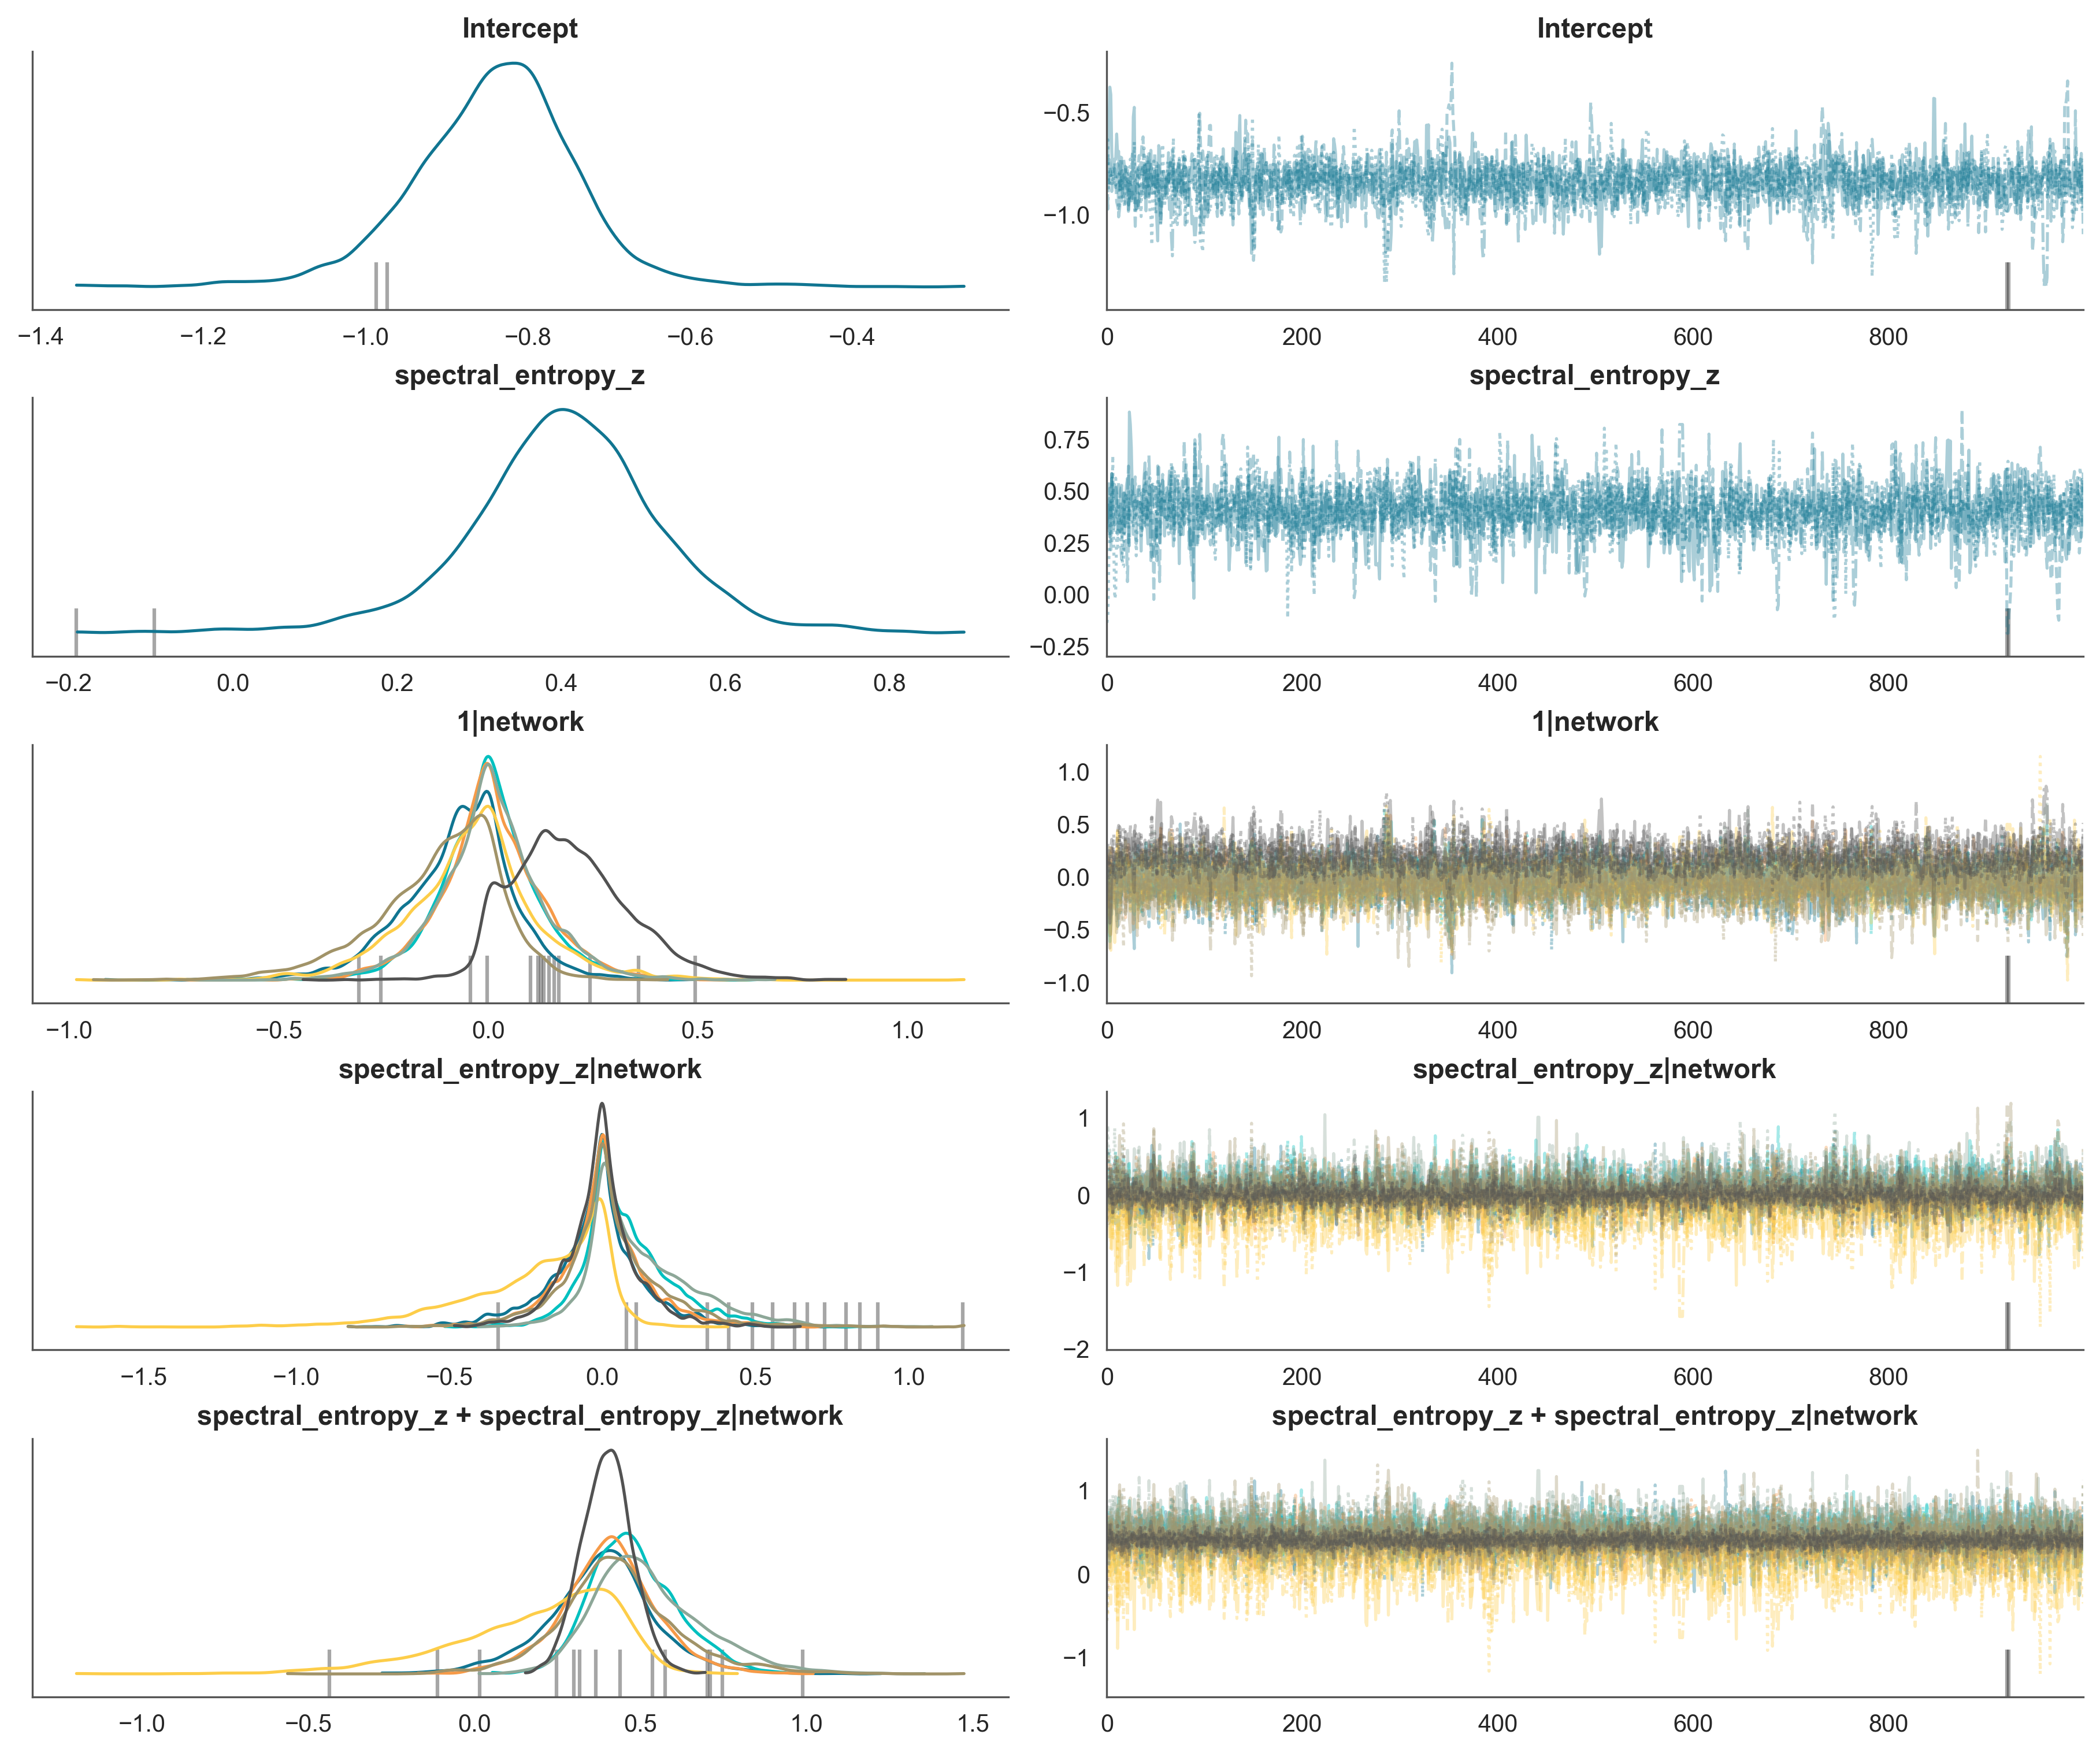

In [118]:
var_names = [
    "Intercept",
    "spectral_entropy_z",
    "1|network",
    "spectral_entropy_z|network",
    "spectral_entropy_z + spectral_entropy_z|network"
]

# Trace plots
plt.close()
az.plot_trace(
    results_tyler,
    combined=True,
    compact=True,
    # figsize=(12, 58),
    var_names=var_names,
)


Sampling: [1|network_offset, 1|network_sigma, Intercept, group_binary, spectral_entropy_z, spectral_entropy_z|network_offset, spectral_entropy_z|network_sigma]
/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_85608/522245997.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


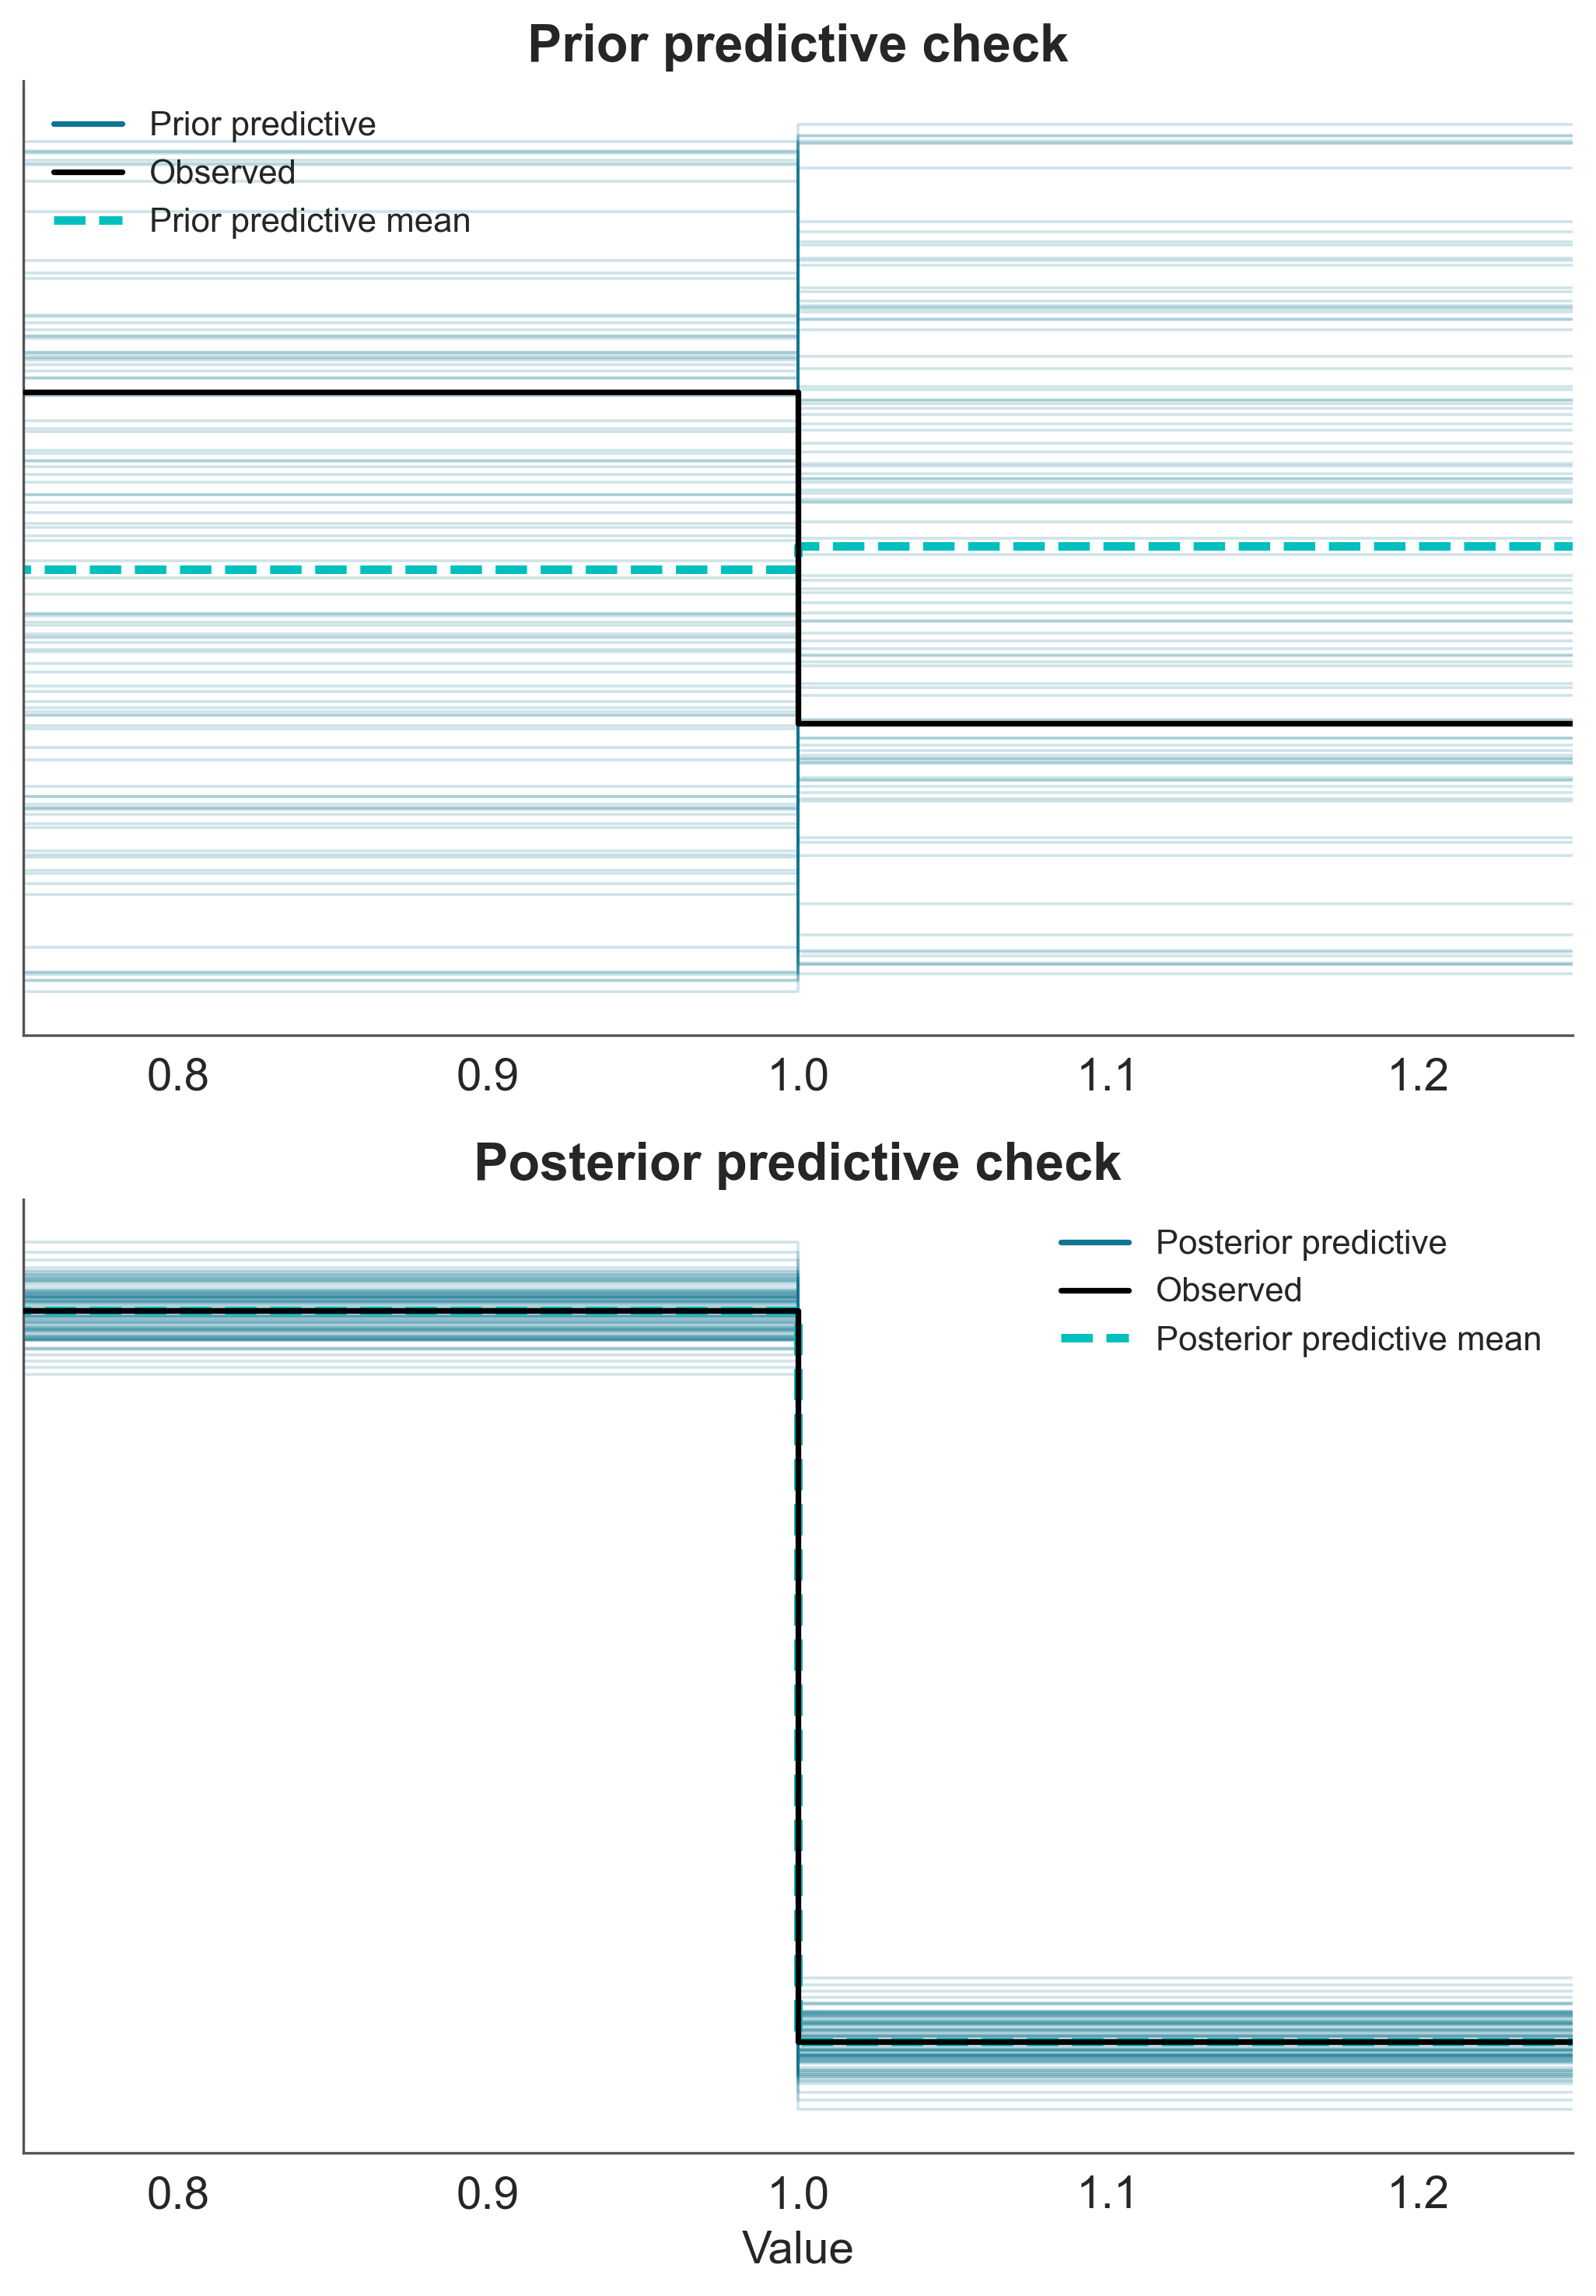

In [113]:
# Get prior predictive data
prior_pred = tyler.prior_predictive()

# Add posterior predictive samples to results_tyler
# Then use predict with kind='pps' for posterior predictive samples
posterior_pred = tyler.predict(
    results_tyler,
    kind='pps',  # Use 'pps' instead of 'response'
    inplace=True
)

# Now you can create your plots
plt.rcParams.update({"font.size": 12})
f, ax = plt.subplots(2, 1, figsize=(7, 10), dpi=300)

# Plot prior predictive check
az.plot_ppc(prior_pred, ax=ax[0], num_pp_samples=100, group="prior")
ax[0].set_title("Prior predictive check")
ax[0].set_xlabel("")
ax[0].set_xlim(0.75, 1.25)  # Zoom in on transition region

# Plot posterior predictive check
az.plot_ppc(results_tyler, ax=ax[1], num_pp_samples=100, group="posterior")
ax[1].set_title("Posterior predictive check")
ax[1].set_xlabel("Value")
ax[1].set_xlim(0.75, 1.25)  # Zoom in on transition region

plt.tight_layout()
plt.show()

/var/folders/bw/qbqmqjxs15q4f_vdkhzt40cc0000gn/T/ipykernel_85608/3097108672.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


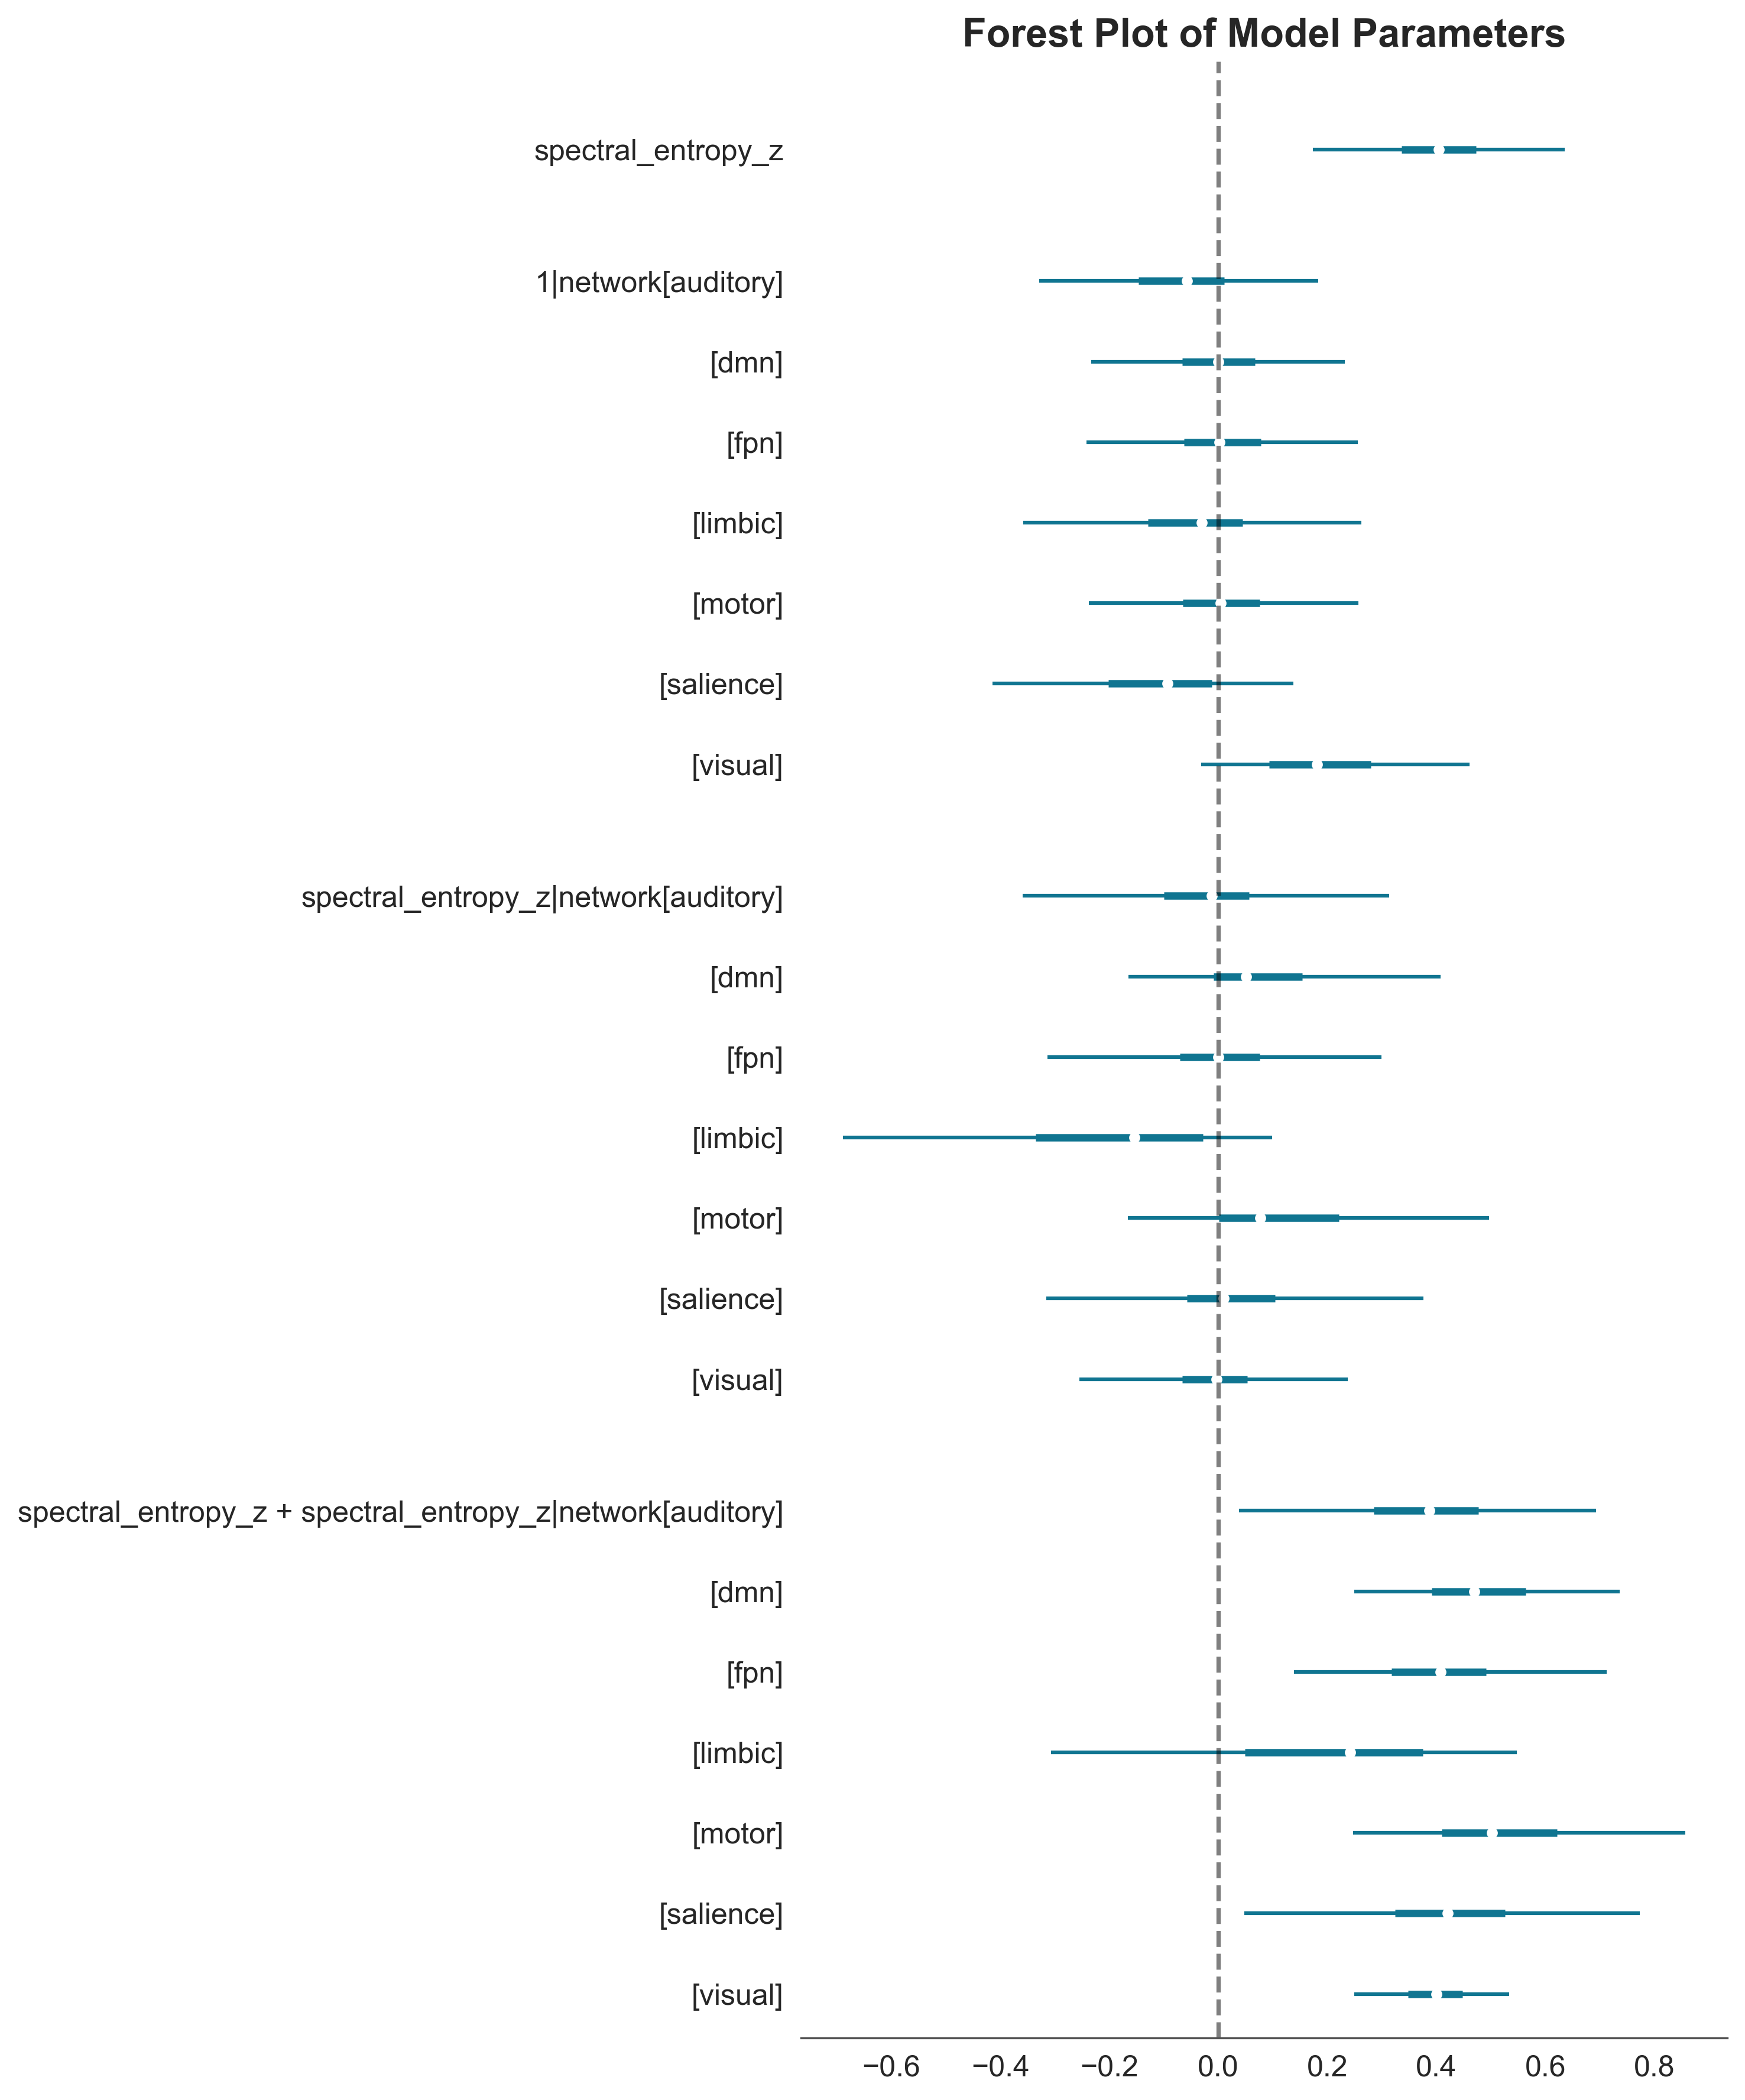

In [125]:
# Basic forest plot of all parameters
az.plot_forest(results_tyler, 
               combined=True,
               var_names=['spectral_entropy_z', 
                         '1|network',
                         'spectral_entropy_z|network',
                         'spectral_entropy_z + spectral_entropy_z|network'],
               figsize=(10, 12),
               textsize=12,
               hdi_prob=0.94)  # 94% HDI intervals

# Add vertical dashed line at x=0
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.title('Forest Plot of Model Parameters')
plt.tight_layout()
plt.show()

In [121]:
# Method 1: Get summary statistics which includes ESS
summary = az.summary(results_tyler)
ess_bulk = summary['ess_bulk']  # ESS for bulk of the distribution
ess_tail = summary['ess_tail']  # ESS for distribution tails

# Method 2: Get detailed ESS statistics
ess_stats = az.ess(results_tyler)

# Method 3: Get ESS by variable
ess_by_var = az.ess(results_tyler, var_names=['spectral_entropy_z'])

# Print the results
print("\nEffective Sample Size Summary:")
print("------------------------------")
print("Bulk ESS range:", f"Min: {ess_bulk.min():.1f}, Max: {ess_bulk.max():.1f}")
print("Tail ESS range:", f"Min: {ess_tail.min():.1f}, Max: {ess_tail.max():.1f}")

# Optional: Show variables with lowest ESS
min_ess = 1000  # minimum recommended ESS
low_ess_vars = summary[summary['ess_bulk'] < min_ess].index
if len(low_ess_vars) > 0:
    print("\nVariables with ESS < 1000:")
    print(summary.loc[low_ess_vars, ['ess_bulk', 'ess_tail', 'r_hat']])


Effective Sample Size Summary:
------------------------------
Bulk ESS range: Min: 885.0, Max: 6393.0
Tail ESS range: Min: 1204.0, Max: 4081.0

Variables with ESS < 1000:
                                  ess_bulk  ess_tail  r_hat
spectral_entropy_z|network_sigma     885.0    1664.0    1.0
